# ZNE protocol for VQE solutions

In this notebook we take an already found VQE solution and execute ZNE protocol.

In [1]:
from vqe_vs_sum import *
from zne import *
from qiskit.algorithms.optimizers import L_BFGS_B
from enum import Enum, auto
from scipy.optimize import minimize
from qiskit_aer.backends import QasmSimulator, AerSimulator
from qiskit import execute
from math import factorial
from scipy.stats import linregress
from pathlib import Path
import time
import json
from scipy.sparse.linalg import eigsh
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from scipy.stats import bootstrap

plt.rcParams.update({"font.size": 14})

### Load VQE data

In [2]:
vqe_foldername = "./vqe_data/Fri, 13 Oct 2023 08:41:22 seq"


with open(vqe_foldername + "/sol.txt", "r") as fp:
    sol_jsonisable = json.load(fp)
with open(vqe_foldername + "/inputs.txt", "r") as fp:
    input_dict = json.load(fp)

h_type = HamiltonianType[input_dict["h_type"]]
ansatz_type = AnsatzType[input_dict["ansatz_type"]]
vqe_starting_point = StartingPoint[input_dict["vqe_starting_point"]]
n_qubits = input_dict["n_qubits"]
ansatz_depth = input_dict["ansatz_depth"]

print(input_dict)

{'h_type': 'ISING', 'ansatz_type': 'CIRCULAR', 'noise_type': 'DEPOL', 'vqe_starting_point': 'SMALL_RANDOM', 'n_qubits': 6, 'n_perms_for_example': 50, 'perms_numbers': [50], 'tests_per_perm_qty': 50, 'ansatz_depth': 4, 'global_seed': 100, 'noise_seed': 0, 'note': 'Ry, Rx, RZZ, layerwise training'}


### Specify ZNE data

In [11]:
global_seed = input_dict["global_seed"]
noise_seed = int(time.time())
noise_type = NoiseType.DEPOL
use_all_perms = False
n_perms_for_other_expts = 50
noise_distribution_type = NoiseDistribution.UNIFORM
# noise_distribution_params = [5e-4, 1/12 * 1e-6] # desired mean and variance, not the "parameters" of the lognormal
noise_distribution_params = [1e-3]

zne_dict = {"vqe_folder": vqe_foldername,
            "global_seed": global_seed,
            "noise_seed": noise_seed,
            "noise_type": noise_type.name,
            "n_perms_for_other_expts": n_perms_for_other_expts,
            "use_all_perms": use_all_perms,
            "noise_distribution_type": noise_distribution_type.name,
            "noise_distribution_params": noise_distribution_params}


# expt_id = time.strftime("%Y %m %d %H:%M:%S", time.gmtime())
# zne_foldername = "./zne_experiments/" + str(expt_id)
# Path(zne_foldername).mkdir(parents=True, exist_ok=False)

zne_foldername = "./zne_experiments/test"
with open(zne_foldername + "/expt_summary.txt", "w") as fp:
    json.dump(zne_dict, fp)

Exact solution

In [12]:
circ = TwoLocal(n_qubits, ['ry', 'rx'], 'rzz',
                entanglement=ansatz_type.name.lower(),
                reps=ansatz_depth)
circ = unpack_twolocal(circ)

h = get_hamiltonian(h_type, n_qubits)


if n_qubits <= 10:
    exact_eigenvalues, _ = np.linalg.eigh(h.to_matrix())
else:
    exact_eigenvalues, _ = eigsh(h.to_spmatrix(), which="SA", k=6)

### Show the distribution of $\epsilon_{jk}$

##### Skip this section if the noise model is stochastic Pauli

In [ ]:
%%time
perturbed_energies = e_gs(circ, h, sol_jsonisable["x"], noise_type)
print(perturbed_energies)

In [ ]:
epsilons = perturbed_energies - np.mean(perturbed_energies)

gates_per_layer = len(perturbed_energies) // ansatz_depth
aggregated_epsilons = np.zeros(gates_per_layer)
aggregated_eij = np.zeros(gates_per_layer)
for i in range(ansatz_depth):
    aggregated_epsilons += epsilons[i * gates_per_layer: (i+1) * gates_per_layer]
aggregated_epsilons = aggregated_epsilons / ansatz_depth
aggregated_eij = np.zeros(gates_per_layer)

In [ ]:
plt.plot(np.arange(len(perturbed_energies)) + 1, 
         perturbed_energies, 'o-')
plt.xlabel("Total gate index")
plt.ylabel("$E_{jk}^l$")

plt.axhline(sol_jsonisable["fun"], color='black')
plt.axhline(np.mean(perturbed_energies), linestyle='-.', color='black', alpha=0.7)
plt.plot(np.arange(len(perturbed_energies)) + 1, 
         perturbed_energies, 'o-', color='tab:blue')

plt.autoscale(False)

for i, x in enumerate(sorted(exact_eigenvalues)):
    if i == 0:
        continue
    # if i >= 5:
    #     break
    plt.axhline(x, linestyle='-', color='gray', alpha=0.5)
    # plt.autoscale(False)


plt.plot(np.arange(gates_per_layer) + 1, 
         aggregated_epsilons  + np.mean(perturbed_energies), 's-')



ylim = plt.gca().get_ylim()
print(ylim)
plt.ylim(bottom=sol_jsonisable["fun"] - 0.025 * (ylim[1] - ylim[0]))

plt.savefig(zne_foldername + "/perturbed_energies.png", dpi=400, bbox_inches='tight')
np.savetxt(zne_foldername + '/perturbed_energies.txt', perturbed_energies)

plt.show()

### Apply ZNE

In [13]:
from itertools import product

In [14]:
def make_pauli_nm(qs, n_qubits):
    assert qs.shape == (n_qubits, n_qubits, 16)
    noise_model = NoiseModel()
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            error_spec = [(s[0] + s[1], qs[i, j, k]) 
                          for k, s in enumerate(product(PAULI_LABELS, repeat=2))]
            error = pauli_error(error_spec)
            noise_model.add_quantum_error(error, ["rzz"], [i, j])
    return noise_model

In [15]:
noise_rng = np.random.default_rng(noise_seed)
rng = np.random.default_rng(global_seed)


if noise_type == NoiseType.STOCH_PAULI:
    size = (n_qubits, n_qubits, 16)
    if noise_distribution_type == NoiseDistribution.UNIFORM:
        qs = noise_rng.uniform(high=noise_distribution_params[0], size=size) / 15
    elif noise_distribution_type == NoiseDistribution.LOGNORMAL:
        sigma2_normal = np.log(1 + noise_distribution_params[1] / noise_distribution_params[0]**2)
        mu_normal = np.log(noise_distribution_params[0]) - 0.5 * sigma2_normal
        qs = noise_rng.lognormal(mean=mu_normal, sigma=(sigma2_normal)**0.5 , size=size) / 15
    else:
        raise ValueError("no such noise type")
else:
    size = (n_qubits, n_qubits)
    if noise_distribution_type == NoiseDistribution.UNIFORM:
        qs = noise_rng.uniform(high=noise_distribution_params[0], size=size)
    elif noise_distribution_type == NoiseDistribution.LOGNORMAL:
        sigma2_normal = np.log(1 + noise_distribution_params[1] / noise_distribution_params[0]**2)
        mu_normal = np.log(noise_distribution_params[0]) - 0.5 * sigma2_normal
        qs = noise_rng.lognormal(mean=mu_normal, sigma=sigma2_normal**0.5, size=size)
    else:
        raise ValueError("no such noise type")
        pass

        
if noise_type == NoiseType.STOCH_PAULI:
    for k in range(16):
        qs[:, :, k] = np.triu(qs[:, :, k], 1) + np.triu(qs[:, :, k], 1).T
        
    qs[:, :, 0] = 1 - np.sum(qs[:, :, 1:], axis=2)
else:
    qs = np.triu(qs, 1) + np.triu(qs, 1).T

In [16]:
def permute_long_qs(qs, P):
    new_qs = np.zeros_like(qs)
    for i in range(16):
        new_qs[:, :, i] = P @ qs[:, :, i] @ P.T
    return new_qs

In [17]:
if use_all_perms:
    n_perms = factorial(n_qubits)
else:
    n_perms = n_perms_for_other_expts
permutations = random_perms(n_qubits, n_perms, rng)
# permutations = random_perms(n_qubits, factorial(n_qubits), rng)

errorsums = np.zeros(n_perms)
energies = np.zeros(n_perms)

for i, perm in tqdm(enumerate(permutations)):
    P = permutation_matrix(perm)
    if noise_type == NoiseType.STOCH_PAULI:
        new_qs = permute_long_qs(qs, P)
        nm = make_pauli_nm(new_qs, n_qubits)
        
        aggregated_qs = np.sum(new_qs[:, :, 1:], axis=2)
        
        errorsums[i] = error_sum(circ, np.zeros(circ.num_qubits), aggregated_qs)
    else:
        new_qs = P @ qs @ P.T
        nm = make_nm(new_qs, noise_type, n_qubits)
        errorsums[i] = error_sum(circ, np.zeros(circ.num_qubits), new_qs)
    energies[i] = get_energy_estimator(circ, h, nm)(sol_jsonisable["x"])

50it [00:04, 12.35it/s]


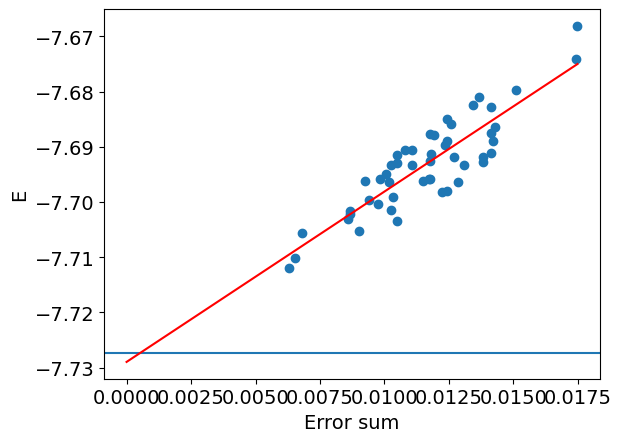

In [18]:
regress_result = linregress(errorsums, energies)
# plt.figure(figsize=(6.4, 4.8))
plt.plot(errorsums, energies, 'o')
plt.axhline(sol_jsonisable["fun"])
plt.plot([0, max(errorsums)], 
         regress_result.intercept 
         + regress_result.slope * np.array([0, max(errorsums)]), 
         'r')

plt.xlabel("Error sum")
plt.ylabel("E")
plt.savefig(zne_foldername + "/perm_fit.png", dpi=400, bbox_inches='tight')

In [19]:
np.savetxt(zne_foldername + '/example_energies.txt', energies)
np.savetxt(zne_foldername + '/example_errorsums.txt', errorsums)

In [20]:
np.savetxt(zne_foldername + '/zne_energy.txt', np.array([regress_result.intercept]))

In [21]:
print(regress_result.intercept -  sol_jsonisable["fun"])

-0.0016401273068593625


In [22]:
np.savetxt(zne_foldername + '/zne_error.txt', 
           np.array([regress_result.intercept -  sol_jsonisable["fun"]]))

### Series of experiments

In [23]:
noise_rng = np.random.default_rng(noise_seed)
rng = np.random.default_rng(global_seed)


def make_unscaled_noise(noise_type, n_qubits, noise_distribution_type):
    if noise_type == NoiseType.STOCH_PAULI:
        size = (n_qubits, n_qubits, 16)
        if noise_distribution_type == NoiseDistribution.UNIFORM:
            qs_unscaled = noise_rng.uniform(high=1, size=size) / 15
        elif noise_distribution_type == NoiseDistribution.LOGNORMAL:
            sigma2_normal = np.log(1 + (1/12) / 0.5**2)
            mu_normal = np.log(1) - 0.5 * sigma2_normal
            qs_unscaled = noise_rng.lognormal(mean=mu_normal, sigma=(sigma2_normal)**0.5 , size=size) / 15
        else:
            raise ValueError("no such noise type")
    else:
        size = (n_qubits, n_qubits)
        if noise_distribution_type == NoiseDistribution.UNIFORM:
            qs_unscaled = noise_rng.uniform(high=1, size=size)
        elif noise_distribution_type == NoiseDistribution.LOGNORMAL:
            sigma2_normal = np.log(1 + (1/12) / 0.5**2)
            mu_normal = np.log(1) - 0.5 * sigma2_normal
            qs_unscaled = noise_rng.lognormal(mean=mu_normal, sigma=sigma2_normal**0.5, size=size)
        else:
            raise ValueError("no such noise type")
            pass


    if noise_type == NoiseType.STOCH_PAULI:
        for k in range(16):
            qs_unscaled[:, :, k] = np.triu(qs_unscaled[:, :, k], 1) + np.triu(qs_unscaled[:, :, k], 1).T

        qs_unscaled[:, :, 0] = 1 - np.sum(qs_unscaled[:, :, 1:], axis=2)
    else:
        qs_unscaled = np.triu(qs_unscaled, 1) + np.triu(qs_unscaled, 1).T
        
    return qs_unscaled

In [47]:
q_amplitudes_0 = np.logspace(-2, -1.5, num=2)
q_amplitudes_1 = np.logspace(-1, 0.5, num=16)
# q_amplitudes_2 = np.array([10**0.5])

q_amplitudes = np.hstack((q_amplitudes_0, q_amplitudes_1))
# / circ.num_nonlocal_gates()

print(np.log10(q_amplitudes))

q_amplitudes = q_amplitudes / circ.num_nonlocal_gates()

[-2.  -1.5 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1
  0.2  0.3  0.4  0.5]


In [48]:
def my_statistic(x, y):
    return linregress(x, y).intercept

In [49]:
zne_energies = np.zeros(len(q_amplitudes))
zne_energy_stderrs = np.zeros_like(zne_energies)
zne_energy_cis = []
zne_bootstrap_results = []

errorsums_all = np.zeros((len(q_amplitudes), n_perms_for_other_expts))
energies_all = np.zeros_like(errorsums_all)

for i, q_max in enumerate(q_amplitudes):
    if noise_type == NoiseType.STOCH_PAULI:
        qs = qs_unscaled * q_max
        qs[:, :, 0] = 1 - np.sum(qs[:, :, 1:], axis=2)
    else:
        qs = qs_unscaled * q_max
    
    permutations = random_perms(n_qubits, n_perms_for_other_expts, rng)
    errorsums = np.zeros(n_perms_for_other_expts)
    energies = np.zeros(n_perms_for_other_expts)
      
    for k, perm in tqdm(enumerate(permutations)):
        P = permutation_matrix(perm)
        if noise_type == NoiseType.STOCH_PAULI:
            new_qs = permute_long_qs(qs, P)
            nm = make_pauli_nm(new_qs, n_qubits)
        
            aggregated_qs = np.sum(new_qs[:, :, 1:], axis=2)        
            errorsums[k] = error_sum(circ, np.zeros(circ.num_qubits), aggregated_qs)
        else:
            new_qs = P @ qs @ P.T
            nm = make_nm(new_qs, noise_type, n_qubits)
            errorsums[k] = error_sum(circ, np.zeros(circ.num_qubits), new_qs)
            
        energies[k] = get_energy_estimator(circ, h, nm)(np.array(sol_jsonisable["x"]))

    boot_res = bootstrap((errorsums, energies), my_statistic, paired=True, vectorized=False, random_state=noise_rng)
    zne_energies[i] = my_statistic(errorsums, energies)
    zne_energy_stderrs[i] = boot_res.standard_error
    zne_energy_cis.append(boot_res.confidence_interval)
    zne_bootstrap_results.append(boot_res)
    
    errorsums_all[i] = errorsums
    energies_all[i] = energies

50it [00:04, 10.79it/s]
50it [00:04, 12.11it/s]
50it [00:03, 12.72it/s]
50it [00:03, 12.76it/s]
50it [00:04, 12.14it/s]
50it [00:04, 12.45it/s]
50it [00:03, 12.61it/s]
50it [00:03, 12.81it/s]
50it [00:03, 12.73it/s]
50it [00:03, 13.05it/s]
50it [00:03, 12.91it/s]
50it [00:04, 12.46it/s]
50it [00:03, 12.71it/s]
50it [00:04, 12.41it/s]
50it [00:03, 13.04it/s]
50it [00:03, 12.83it/s]
50it [00:04, 12.33it/s]
50it [00:03, 12.55it/s]


In [50]:
zne_energies_vs_gap = (zne_energies - exact_eigenvalues[0]) / (exact_eigenvalues[1] - exact_eigenvalues[0])
cis = np.array([[t.low for t in zne_energy_cis], [t.high for t in zne_energy_cis]])

Text(0.05, 1.0, '$y\\sim~x^{1.2}$')

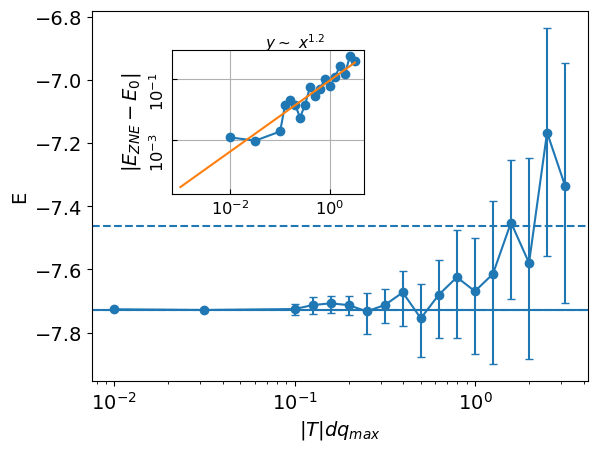

In [51]:
plt.errorbar(q_amplitudes * circ.num_nonlocal_gates(), 
             zne_energies,
             yerr=abs(cis - zne_energies),
             markersize=6, capsize=3, marker='o')

plt.axhline(sol_jsonisable["fun"])

    
for i, x in enumerate(sorted(exact_eigenvalues)):
    if i >= 2:
        break
    plt.axhline(x, linestyle='--')

# plt.axhline((sol_jsonisable["fun"] - exact_eigenvalues[0]) / (exact_eigenvalues[1] - exact_eigenvalues[0]))
plt.ylabel("E")
plt.xlabel(r"$|T|dq_{max}$")

# plt.savefig(foldername + "/zne_vs_qG", dpi=400, bbox_inches='tight')


# for i in range(len(q_amplitudes)):
#     if i <=3:
#         continue
#     # plt.scatter(np.ones(energies_all[i].shape) * q_amplitudes[i] * circ.num_nonlocal_gates(), 
#     #             energies_all[i], alpha=0.5)
#     plt.boxplot(energies_all[i], positions=[q_amplitudes[i] * circ.num_nonlocal_gates()],
#                widths=q_amplitudes[i] * circ.num_nonlocal_gates() * 0.2)



plt.gca().set_xscale("log")


a = plt.axes([0.25, 0.5, 0.3, 0.3])
a.loglog(q_amplitudes * circ.num_nonlocal_gates(), abs(zne_energies - sol_jsonisable["fun"]), 'o-')
# a.errorbar(q_amplitudes * circ.num_nonlocal_gates(), abs(zne_energies - sol_jsonisable["fun"]), 
#            yerr=abs(cis - zne_energies), 
#            markersize=6, capsize=3, marker='o')
# a.set_xscale("log")
# a.set_yscale("log")

a.grid()
# a.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1], labels=[r'$10^{-4}$', '', '', '', '1'])
a.tick_params(direction='in', labelsize="small")
a.tick_params(axis='y', labelrotation=90)
a.set_ylabel(r"$|E_{ZNE} - E_0|$")

regress_result = linregress(np.log10(q_amplitudes * circ.num_nonlocal_gates()), np.log10(abs(zne_energies - sol_jsonisable["fun"])))

a.loglog(np.logspace(-3, 0.5, num=51), 
         np.logspace(-3, 0.5, num=51)**regress_result.slope * 10**regress_result.intercept)

a.text(0.05, 1., r"$y\sim~x^{{{0:1.1f}}}$".format(regress_result.slope), fontsize=11)

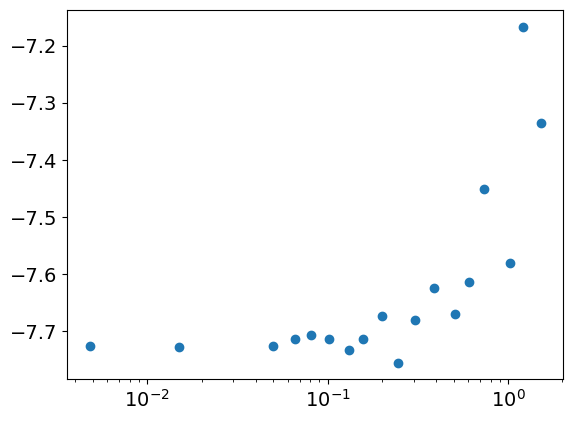

In [60]:
plt.semilogx(np.mean(errorsums_all, axis=1), zne_energies, 'o')

In [58]:
gap_rate = 10**((np.log10(exact_eigenvalues[1] - exact_eigenvalues[0]) - regress_result.intercept) 
     / regress_result.slope)

print(gap_rate)

2.4931048587587332
